# Heat transport in a 1-D pipe

In [ ]:
def step_1_D_cylindrical_bulk(dr, dt, k, rho, cp, radius, temp_arr):
    
    # Do not deal with the elements in the first and the last
    temp_arr_cp = temp_arr.copy()
    alpha = k / (rho * cp)
    m_factor = dr**2/(alpha*dt)
    # You have to be really careful that the np.roll(temp_arr_cp, -1) is T_i+1
    first_derivative_term = 1/m_factor * dr/radius[1:-1] *(np.roll(temp_arr_cp, -1)[1:-1]-np.roll(temp_arr_cp, 0)[1:-1])

    second_derivative_term = 1/m_factor * (np.roll(temp_arr_cp, 1)[1:-1]+np.roll(temp_arr_cp, -1)[1:-1]-2*np.roll(temp_arr_cp, 0)[1:-1])
    temp_arr_cp[1:-1] += first_derivative_term + second_derivative_term

    return temp_arr_cp

# Refresh the temperature in the interface
def step_1_D_cylindrical_boundary(dr, h, k, T_inf, T_next):
    
    factor = h*dr/k
    nominator = factor*T_inf + T_next
    # print(nominator)
    denominator = factor + 1
    T_result = nominator/denominator

    return T_result

def step_1_D_cylindrical_interface(k1,k2,T1,T2):
    nominator = k1*T1 + k2*T2
    denominator = k1 + k2
    T_result = nominator/denominator
    print(f'Interface temperature = {T_result}')
    return T_result

In [46]:
import numpy as np
import pandas as pd

def step_1_D_cylindrical_bulk(dr, dt, k, rho, cp, radius, temp_arr):
    # Do not deal with the elements in the first and the last
    temp_arr_cp = temp_arr.copy()
    alpha = k / (rho * cp)
    m_factor = dr**2 / (alpha * dt)
    # You have to be really careful that the np.roll(temp_arr_cp, -1) is T_i+1
    first_derivative_term = 1 / m_factor * dr / radius[1:-1] * (np.roll(temp_arr_cp, -1)[1:-1] - np.roll(temp_arr_cp, 0)[1:-1])

    second_derivative_term = 1 / m_factor * (np.roll(temp_arr_cp, 1)[1:-1] + np.roll(temp_arr_cp, -1)[1:-1] - 2 * np.roll(temp_arr_cp, 0)[1:-1])
    temp_arr_cp[1:-1] += first_derivative_term + second_derivative_term

    return temp_arr_cp

# Refresh the temperature in the interface
def step_1_D_cylindrical_boundary(dr, h, k, T_inf, T_next):
    factor = h * dr / k
    nominator = factor * T_inf + T_next
    denominator = factor + 1
    T_result = nominator / denominator

    return T_result

def step_1_D_cylindrical_interface(k1, k2, T1, T2):
    nominator = k1 * T1 + k2 * T2
    denominator = k1 + k2
    T_result = nominator / denominator
    print(f'Interface temperature = {T_result}')

class cylindrical_pipe(object):
    def __init__(self, dt, t_final, dr, T_initial, insu_thickness):
        self.dr = dr
        self.dt = dt  
        self.insu_thickness = insu_thickness  
        self.t_final = t_final  # Final time, seconds
        self.T_initial = T_initial  # K

        self.k_cera = 3.0  # Thermal conductivity of ceramic, W/(m·K)
        self.k_insu = 0.2  # Thermal conductivity of insulation, W/(m·K)
        self.rho_cera, self.c_cera = 2600, 1150  # Density and specific heat of ceramic, J/(kg·K)
        self.rho_insu, self.c_insu = 600, 200    # Density and specific heat of insulation, J/(kg·K)

        # Calculate thermal diffusivity
        self.alpha_cera = self.k_cera / (self.rho_cera * self.c_cera)  # Thermal diffusivity of ceramic
        self.alpha_insu = self.k_insu / (self.rho_insu * self.c_insu)  # Thermal diffusivity of insulation

        # Geometric parameters (units: m)
        self.r_i = 0.025  # Inner radius
        self.r_m = self.r_i + 0.025  # Interface radius
        self.r_o = self.r_m + self.insu_thickness  # Outer radius of insulation layer (outer radius + insulation thickness)
        
        self.r_cera = np.arange(self.r_i, self.r_m + dr, dr)  # Radial positions for ceramic
        self.r_insu = np.arange(self.r_m, self.r_o + dr, dr)  # Radial positions for insulation

        # Initial conditions
        self.T_cera_0 = np.ones_like(self.r_cera) * self.T_initial
        self.T_insu_0 = np.ones_like(self.r_insu) * self.T_initial

        # Boundary conditions
        self.T_inner = 1500  # K Inner surface temperature
        self.T_outer = 298   # K Outer surface temperature

        self.h_outer = 10  # W/(m^2·K) Convection heat transfer coefficient for outer surface
        self.h_inner = 500  # W/(m^2·K) Convection heat transfer coefficient for inner surface

        self.heat_inner = []
        self.heat_outer = []
        self.heat_interface = []

    def run(self):
        # Start time loop
        T_cera = self.T_cera_0.copy()
        T_insu = self.T_insu_0.copy()

        self.heat_inner = []
        self.heat_outer = []
        self.heat_interface = []

        for t in range(int(self.t_final / self.dt)):
            # Update temperature in the ceramic region
            T_cera[0] = step_1_D_cylindrical_boundary(self.dr, self.h_inner, self.k_cera, self.T_inner, T_cera[1])
            print(f'T_cera[0] = {T_cera[0]}')
            T_cera = step_1_D_cylindrical_bulk(self.dr, self.dt, self.k_cera, self.rho_cera, self.c_cera, self.r_cera, T_cera)
            
            # Update temperature in the insulation region
            T_insu[-1] = step_1_D_cylindrical_boundary(self.dr, self.h_outer, self.k_insu, self.T_outer, T_insu[-2])
            T_insu = step_1_D_cylindrical_bulk(self.dr, self.dt, self.k_insu, self.rho_insu, self.c_insu, self.r_insu, T_insu)
            print(f'T_insu[-1] = {T_insu[-1]}')
            
            # Update interface temperature
            print(f"Temperature around interface \n inner = {T_cera[-2]} \n outer = {T_insu[1]}")
            T_cera[-1] = T_insu[0] = step_1_D_cylindrical_interface(self.k_cera, self.k_insu, T_cera[-2], T_insu[1])
            
            if np.isnan(T_cera).any() or np.isnan(T_insu).any():
                raise ValueError('There is NaN in your calculation, automatically stopped')

            # Calculate heat transfer rate
            self.heat_inner.append(self.h_inner * (self.T_inner - T_cera[0]))
            self.heat_outer.append(self.h_outer * (T_insu[-1] - self.T_outer))
            self.heat_interface.append(-1 * (T_insu[1] - T_insu[0]) * self.k_insu / self.dr)

            # Refresh log
            T_cera_pd = pd.DataFrame([T_cera])
            T_insu_pd = pd.DataFrame([T_insu])
            T_cera_pd.to_csv(f'T_cera_{self.dt}_{self.dr}_{self.insu_thickness}.csv', mode='a', header=False)
            T_insu_pd.to_csv(f'T_insu_{self.dt}_{self.dr}_{self.insu_thickness}.csv', mode='a', header=False)

In [ ]:
t_final = 500 # Final tile [s]
T_initial = 300 # K
dt = 0.01  # time step [s]
dr = 0.001  # radial step [m]
insu_thickness_ls = np.arange(dr, 0.1 + dr, dr*10) # From 1[mm] to 1[dm]
pipe_ls = []
heat_inner_ls = []

for insu_thickness in insu_thickness_ls:
    pipe = cylindrical_pipe(dt, t_final, dr, T_initial, insu_thickness)
    pipe.run()
    heat_inner_ls.append(pipe.heat_inner)
    pipe_ls.append(pipe)



In [61]:
heat_outer_ls = []
for pipe in pipe_ls:
    heat_outer_ls.append(pipe.heat_outer)


C:\Users\wcl-1\AppData\Local\Temp\ipykernel_31344\2729669781.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues', len(heat_outer_ls)+3)


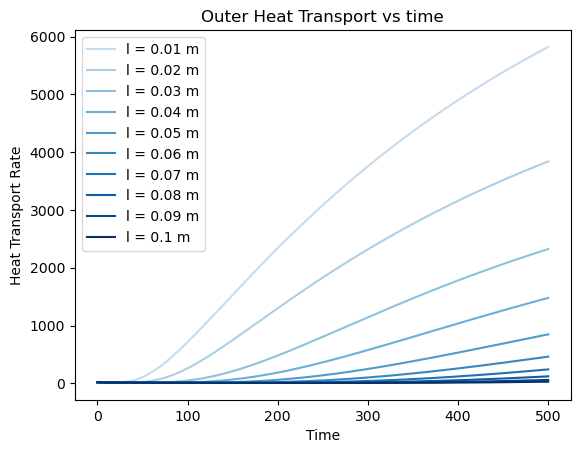

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
t_ls = np.arange(0, t_final, dt)

fig, ax = plt.subplots()
# print(len(T_cera_log_selected))
cmap = cm.get_cmap('Blues', len(heat_outer_ls)+3)

for i in range(len(heat_outer_ls)):
    # print(i)
    ax.plot(t_ls, heat_outer_ls[i], label=f'l = {(i+1)*0.01} m', color=cmap(i+3))


ax.legend()

ax.set_title('Outer Heat Transport vs time')
ax.set_xlabel('Time')
ax.set_ylabel('Heat Transport Rate')


plt.show()

C:\Users\wcl-1\AppData\Local\Temp\ipykernel_31344\1964095488.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues', len(heat_outer_ls)+3)
C:\Users\wcl-1\AppData\Local\Temp\ipykernel_31344\1964095488.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


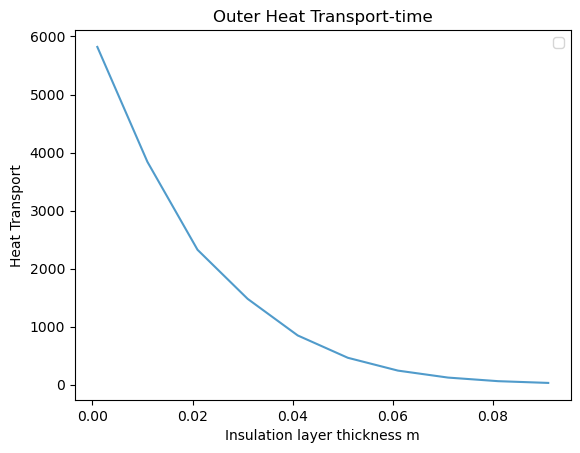

In [64]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
heat_outer_pd = pd.DataFrame(heat_outer_ls)
t_ls = np.arange(0, t_final, dt)
fig, ax = plt.subplots()
# print(len(T_cera_log_selected))
cmap = cm.get_cmap('Blues', len(heat_outer_ls)+3)


ax.plot(insu_thickness_ls, heat_outer_pd.iloc[:,-1], color=cmap(7))


ax.legend()


ax.set_title('Outer Heat Transport-time')
ax.set_xlabel('Insulation layer thickness m')
ax.set_ylabel('Heat Transport')


plt.show()

C:\Users\wcl-1\AppData\Local\Temp\ipykernel_31344\1319239266.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Oranges', len(heat_inner_ls)+3)


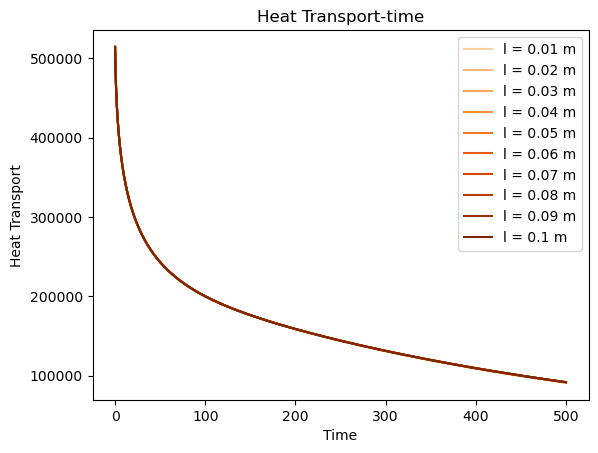

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
t_ls = np.arange(0, t_final, dt)

fig, ax = plt.subplots()
# print(len(T_cera_log_selected))
cmap = cm.get_cmap('Oranges', len(heat_inner_ls)+3)

for i in range(len(heat_inner_ls)):
    # print(i)
    ax.plot(t_ls, heat_inner_ls[i], label=f'l = {(i+1)*0.01} m', color=cmap(i+3))

ax.legend()


ax.set_title('Heat Transport-time')
ax.set_xlabel('Time')
ax.set_ylabel('Heat Transport')

plt.show()

In [55]:
heat_inner_pd = pd.DataFrame(heat_inner_ls)

C:\Users\wcl-1\AppData\Local\Temp\ipykernel_31344\2951156618.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Oranges', len(heat_inner_ls)+3)
C:\Users\wcl-1\AppData\Local\Temp\ipykernel_31344\2951156618.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


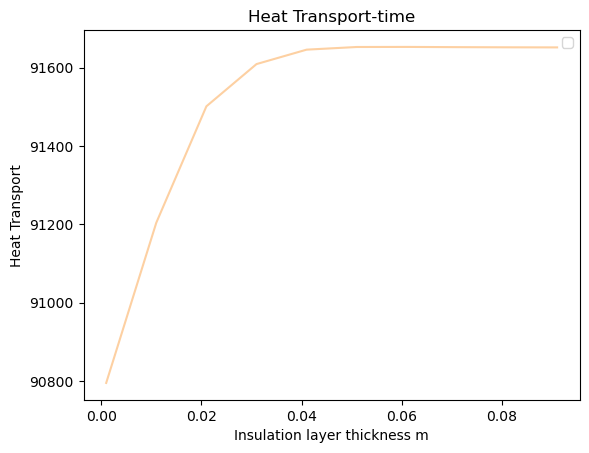

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
t_ls = np.arange(0, t_final, dt)

fig, ax = plt.subplots()

# print(len(T_cera_log_selected))
cmap = cm.get_cmap('Oranges', len(heat_inner_ls)+3)


ax.plot(insu_thickness_ls, heat_inner_pd.iloc[:,-1], color=cmap(3))


ax.legend()

ax.set_title('Heat Transport-time')
ax.set_xlabel('Insulation layer thickness m')
ax.set_ylabel('Heat Transport')

plt.show()

## Setting parameters

In [ ]:
import numpy as np

# Physical parameters
k_cera = 3.0  # Thermal conductivity of ceramic, W/(m·K)
k_insu = 0.2  # Thermal conductivity of insulation, W/(m·K)
rho_cera, c_cera = 2600, 1150  # Density and specific heat of ceramic, J/(kg·K)
rho_insu, c_insu = 600, 200    # Density and specific heat of insulation, J/(kg·K)

# Calculate thermal diffusivity
alpha_cera = k_cera / (rho_cera * c_cera)  # Thermal diffusivity of ceramic
alpha_insu = k_insu / (rho_insu * c_insu)  # Thermal diffusivity of insulation
print(f'alpha_cera = {alpha_cera}')
print(f'alpha_insu = {alpha_insu}')

# Geometric parameters (units: m)
r_i = 0.025  # Inner radius
r_m = r_i + 0.025  # Interface radius
r_o = r_m + 0.050  # Outer radius of insulation layer (outer radius + insulation thickness)

# Time parameters
t_final = 500  # Final time, seconds
dt = 0.01  # Time step, seconds

# Spatial discretization
dr = 0.001  # Radial step, m
r_cera = np.arange(r_i, r_m + dr, dr)  # Radial positions for ceramic
r_insu = np.arange(r_m, r_o + dr, dr)  # Radial positions for insulation

# Initial conditions
T_initial = 300  # K
T_cera_0 = np.ones_like(r_cera) * T_initial
T_insu_0 = np.ones_like(r_insu) * T_initial

# Boundary conditions
T_inner = 1500  # K Inner surface temperature
T_outer = 298   # K Outer surface temperature

h_outer = 10  # W/(m^2·K) Convection heat transfer coefficient for outer surface
h_inner = 500  # W/(m^2·K) Convection heat transfer coefficient for inner surface

# Check the results
print(r_cera[0])
print(r_cera[-1])
print(r_insu[0])
print(r_insu[-1])

## Define the function to refresh the parameters

In [ ]:
# alpha = k_cera / (rho_cera * c_cera)
# M = 2
# dt= dr**2/(alpha*M)
# print(dt)

In [ ]:
# alpha = k_insu / (rho_insu * c_insu)
# M = 2
# dt= dr**2/(alpha*M)
# print(dt)

In [4]:
# Refresh the temperature in the bulk
def step_1_D_cylindrical_bulk(dr, dt, k, rho, cp, radius, temp_arr):
    
    # Do not deal with the elements in the first and the last
    temp_arr_cp = temp_arr.copy()
    alpha = k / (rho * cp)
    m_factor = dr**2/(alpha*dt)
    # You have to be really careful that the np.roll(temp_arr_cp, -1) is T_i+1
    first_derivative_term = 1/m_factor * dr/radius[1:-1] *(np.roll(temp_arr_cp, -1)[1:-1]-np.roll(temp_arr_cp, 0)[1:-1])

    second_derivative_term = 1/m_factor * (np.roll(temp_arr_cp, 1)[1:-1]+np.roll(temp_arr_cp, -1)[1:-1]-2*np.roll(temp_arr_cp, 0)[1:-1])
    temp_arr_cp[1:-1] += first_derivative_term + second_derivative_term

    return temp_arr_cp

# Refresh the temperature in the interface
def step_1_D_cylindrical_boundary(dr, h, k, T_inf, T_next):
    
    factor = h*dr/k
    nominator = factor*T_inf + T_next
    # print(nominator)
    denominator = factor + 1
    T_result = nominator/denominator

    return T_result

def step_1_D_cylindrical_interface(k1,k2,T1,T2):
    nominator = k1*T1 + k2*T2
    denominator = k1 + k2
    T_result = nominator/denominator
    print(f'Interface temperature = {T_result}')
    return T_result

## 更新参数

In [ ]:
import pandas as pd

T_cera = T_cera_0.copy()
T_insu = T_insu_0.copy()

for t in range(int(t_final/dt)):

    T_cera[0] = step_1_D_cylindrical_boundary(dr, h_inner, k_cera,T_inner, T_cera[1])
    print(f'T_cera[0] = {T_cera[0]}')
    T_cera = step_1_D_cylindrical_bulk(dr, dt, k_cera, rho_cera, c_cera, r_cera, T_cera)
    # print(T_cera[0])    

    T_insu[-1] = step_1_D_cylindrical_boundary(dr, h_outer, k_insu, T_outer, T_insu[-2])
    T_insu = step_1_D_cylindrical_bulk(dr, dt, k_insu, rho_insu, c_insu, r_insu, T_insu)
    print(f'T_insu[-1] = {T_insu[-1]}')

    print(f"Temperature around interface \n inner = {T_cera[-2]} \n outer = {T_insu[1]}")
    T_cera[-1] = T_insu[0] = step_1_D_cylindrical_interface(k_cera,k_insu,T_cera[-2],T_insu[1])
    # print(f'T_cera[-1] = {T_cera[-1]}')
    if np.isnan(T_cera).any() or np.isnan(T_insu).any() :
        raise ValueError('There in nan in your calculation, automatically stoppd')

    # Refreash log
    T_cera_pd = pd.DataFrame([T_cera])
    T_insu_pd = pd.DataFrame([T_insu])
    T_cera_pd.to_csv(f'T_cera_{dt}_{dr}.csv', mode='a', header=False)
    T_insu_pd.to_csv(f'T_insu_{dt}_{dr}.csv', mode='a', header=False)



## 数据作图

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
T_cera_log = pd.read_csv(f'T_cera_{dt}_{dr}.csv')
every_n = 10000
# every_n = 500
T_cera_log_selected = T_cera_log[every_n-2::every_n]
# print(T_cera_log_selected.iloc[1])

In [ ]:


fig, ax = plt.subplots()

# print(len(T_cera_log_selected))
cmap = cm.get_cmap('Oranges', len(T_cera_log_selected)+3)


for i in range(len(T_cera_log_selected)):
    print(i)
    ax.plot(r_cera, T_cera_log_selected.iloc[i][1:], label=f't = {(i+1)*every_n*dt} s', color=cmap(i+3))


ax.legend()


ax.set_title('Temperature Distribution Along Ceramic Radius Over Time')
ax.set_xlabel('Ceramic Radius (m)')
ax.set_ylabel('Temperature (K)')

plt.show()

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
T_insu_log = pd.read_csv(f'T_insu_{dt}_{dr}.csv')
# every_n = 500
every_n = 10000

T_insu_log_selected = T_insu_log[every_n-2::every_n]
# print(T_insu_log_selected.iloc[1])

0
1
2
3
4


C:\Users\wcl-1\AppData\Local\Temp\ipykernel_31344\364648636.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('Blues', len(T_insu_log_selected)+3)


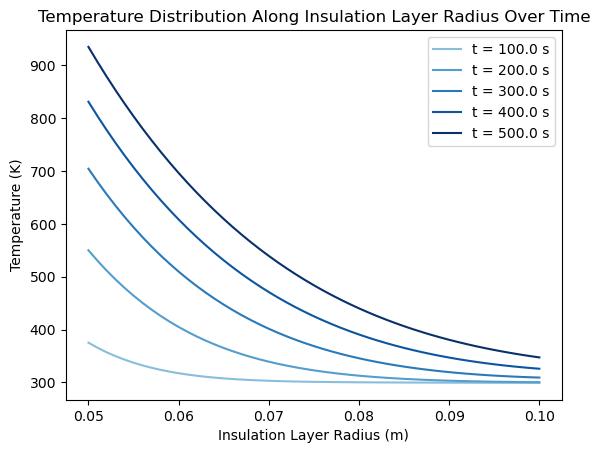

In [68]:


fig, ax = plt.subplots()

# print(len(T_cera_log_selected))
cmap = cm.get_cmap('Blues', len(T_insu_log_selected)+3)


for i in range(len(T_insu_log_selected)):
    print(i)
    ax.plot(r_insu, T_insu_log_selected.iloc[i][1:], label=f't = {(i+1)*every_n*dt} s', color=cmap(i+3))


ax.legend()


ax.set_title('Temperature Distribution Along Insulation Layer Radius Over Time')
ax.set_xlabel('Insulation Layer Radius (m)')
ax.set_ylabel('Temperature (K)')


plt.show()
plt.show()

In [70]:
t_ls = np.arange(0, t_final-dt, dt)

T_cera = pd.read_csv(f'T_cera_{dt}_{dr}.csv')
T_insu = pd.read_csv(f'T_insu_{dt}_{dr}.csv')

T_inner = T_cera.iloc[:,1]
T_interface = T_cera.iloc[:,-1]
T_outer = T_insu.iloc[:,-1]

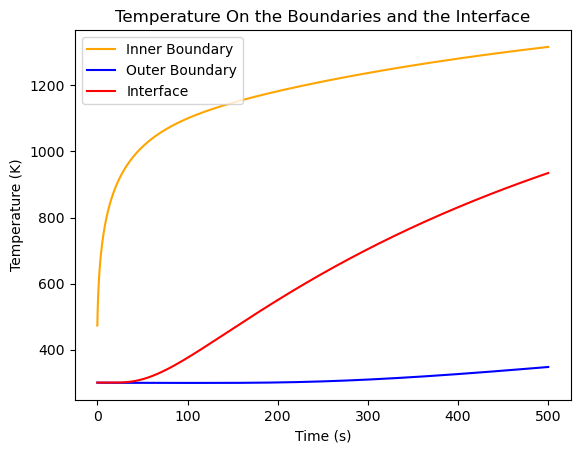

In [71]:

fig, ax = plt.subplots()

ax.plot(t_ls, T_inner, label=f'Inner Boundary', color='orange')
ax.plot(t_ls, T_outer, label=f'Outer Boundary', color='blue')
ax.plot(t_ls, T_interface, label=f'Interface', color='red')

ax.legend()


ax.set_title('Temperature On the Boundaries and the Interface')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Temperature (K)')


plt.show()
plt.show()

In [ ]:
fig, ax = plt.subplots()

# ax.plot(t_ls, T_inner, label=f'Inner Boundary', color='orange')
# ax.plot(t_ls, T_outer, label=f'Outer Boundary', color='blue')
ax.plot(t_ls, T_interface, label=f'Interface', color='red')

ax.legend()


ax.set_title('Temperature On the Boundaries and the Interface')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Temperature (K)')


plt.show()
plt.show()